In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sqlalchemy import create_engine

%matplotlib inline

In [2]:
#Connect Python to a DB
engine = create_engine("sqlite:///mta.db")

In [3]:
all_tables = engine.table_names()
all_tables

['df_covid',
 'df_mta_cleaned',
 'df_mta_cleaned1',
 'df_mta_cleaned3',
 'df_stations_mapping',
 'mta_data']

In [4]:
#Import the MTA data and only inculde 12am data points to calculate to daily entries;
df_mta = pd.read_sql('''
                      SELECT *
                      FROM
                        (SELECT CA
                              ,UNIT AS unit
                              ,SCP
                              ,STATION AS station
                              ,LINENAME AS linename
                              ,DIVISION AS division
                              ,date(substr(DATE,7,7) ||'-'||substr(DATE,1,2)||'-'||substr(DATE,4,2)) AS date
                              ,DESC AS desc
                              ,CAST(ENTRIES AS INT) AS entries
                              ,CAST(EXITS AS INT) AS exits
                          FROM mta_data 
                          WHERE TIME = "00:00:00")
                       WHERE date between "2020-03-01" and "2020-12-31"
                     ''', engine)

In [5]:
df_mta.head()

,CA,unit,SCP,station,linename,division,date,desc,entries,exits
0,A033,R170,02-00-00,14 ST-UNION SQ,LNQR456W,BMT,2020-03-01,REGULAR,326919,995477
1,A033,R170,02-00-00,14 ST-UNION SQ,LNQR456W,BMT,2020-03-02,REGULAR,327136,996201
2,A033,R170,02-00-00,14 ST-UNION SQ,LNQR456W,BMT,2020-03-03,REGULAR,328115,999054
3,A033,R170,02-00-00,14 ST-UNION SQ,LNQR456W,BMT,2020-03-04,REGULAR,329220,1002104
4,A033,R170,02-00-00,14 ST-UNION SQ,LNQR456W,BMT,2020-03-05,REGULAR,330246,1005296


### Data Wrangling

In [6]:
df_mta.sort_values(["CA","unit","SCP","station", "date"],
                  inplace = True, ascending = False)

In [7]:
#Remove dupicated rows because those are Recovr Aud records
df_mta.drop_duplicates(subset=["CA","unit","SCP","station", "date"], inplace = True)

In [8]:
df_mta.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 726156 entries, 726166 to 11098
Data columns (total 10 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   CA        726156 non-null  object
 1   unit      726156 non-null  object
 2   SCP       726156 non-null  object
 3   station   726156 non-null  object
 4   linename  726156 non-null  object
 5   division  726156 non-null  object
 6   date      726156 non-null  object
 7   desc      726156 non-null  object
 8   entries   726156 non-null  int64 
 9   exits     726156 non-null  int64 
dtypes: int64(2), object(8)
memory usage: 60.9+ MB


In [9]:
#Calculate the daily entries by using each day's entries to minus the previous date
df_mta[["date_next", "entries_next"]] = df_mta.groupby(["CA","unit","SCP","station"])["date","entries"].shift(1)


<ipython-input-9-e24b04766428>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_mta[["date_next", "entries_next"]] = df_mta.groupby(["CA","unit","SCP","station"])["date","entries"].shift(1)


In [10]:
def get_daily_counts(df, max_counter = 1500000):
    counter = df["entries_next"] - df["entries"]
    if counter < 0:
        counter = -counter
    if counter > max_counter:
        return 0
    return counter

In [11]:
df_mta["daily_entries"] = df_mta.apply(get_daily_counts, axis = 1)

In [12]:
df_mta.head()

,CA,unit,SCP,station,linename,division,date,desc,entries,exits,date_next,entries_next,daily_entries
726166,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,2020-12-31,REGULAR,5554,541,NaN,NaN,NaN
726165,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,2020-12-30,REGULAR,5554,541,2020-12-31,5554.0,0.0
726164,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,2020-12-29,REGULAR,5554,541,2020-12-30,5554.0,0.0
726163,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,2020-12-28,REGULAR,5554,541,2020-12-29,5554.0,0.0
726162,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,2020-12-27,REGULAR,5554,541,2020-12-28,5554.0,0.0


In [13]:
from datetime import datetime, timedelta

In [14]:
df_mta['date'] = pd.to_datetime(df_mta['date'], format='%Y-%m-%d')

#week begins on Monday
df_mta['week_begin'] = df_mta['date'] - pd.to_timedelta(df_mta['date'].dt.dayofweek, unit='d')


In [ ]:
#Upload the cleaned mta data into mta.db for SQl practice
#df_mta.to_sql("df_mta_cleaned", engine, index = False) 

In [15]:
df_mta.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 726156 entries, 726166 to 11098
Data columns (total 14 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   CA             726156 non-null  object        
 1   unit           726156 non-null  object        
 2   SCP            726156 non-null  object        
 3   station        726156 non-null  object        
 4   linename       726156 non-null  object        
 5   division       726156 non-null  object        
 6   date           726156 non-null  datetime64[ns]
 7   desc           726156 non-null  object        
 8   entries        726156 non-null  int64         
 9   exits          726156 non-null  int64         
 10  date_next      721682 non-null  object        
 11  entries_next   721682 non-null  float64       
 12  daily_entries  721682 non-null  float64       
 13  week_begin     726156 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(2), int64(2), obje

In [16]:
#import the remote_complex_lookup.csv to map turnstiles to borough
df_stations_mapping = pd.read_csv("remote_complex_lookup.csv")
df_stations_mapping.head()

,remote,booth,complex_id,station,line_name,division,Borough
0,R001,A060,635.0,WHITEHALL ST,R1,BMT,M
1,R001,A058,635.0,WHITEHALL ST,R1,BMT,M
2,R001,R101S,635.0,SOUTH FERRY,R1,IRT,M
3,R002,A077,628.0,FULTON ST,ACJZ2345,BMT,M
4,R002,A081,628.0,FULTON ST,ACJZ2345,BMT,M


In [ ]:
#df_stations_mapping.to_sql("df_stations_mapping", engine, index = False)

In [17]:
#Create the master dataset to map each turnstile into a borough
df_mta_master = pd.read_sql('''
                      select a.*
                            ,lower(b.Borough) as borough
                      from df_mta_cleaned3 a LEFT join
                      (select remote,Borough
                      from df_stations_mapping
                      group by 1,2) b
                      on a.unit = b.remote
                      WHERE a.daily_entries > 0;
                      ''',engine)

In [24]:
df_mta_master[df_mta_master.borough.isna()]["station"].unique()

array(['RIT-ROOSEVELT', 'RIT-MANHATTAN', 'CITY / BUS', 'EXCHANGE PLACE',
       'ORCHARD BEACH', 'JFK JAMAICA CT1', 'HOWARD BCH JFK'], dtype=object)

In [25]:
df_mta_master['date'] = pd.to_datetime(df_mta_master['date'], format='%Y-%m-%d')
df_mta_master['week_begin'] = pd.to_datetime(df_mta_master['week_begin'], format='%Y-%m-%d')
df_mta_master["year_month"] = df_mta_master["date"].dt.strftime('%Y-%m')

In [27]:
df_mta_master.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 638662 entries, 0 to 638661
Data columns (total 16 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   CA             638662 non-null  object        
 1   unit           638662 non-null  object        
 2   SCP            638662 non-null  object        
 3   station        638662 non-null  object        
 4   linename       638662 non-null  object        
 5   division       638662 non-null  object        
 6   date           638662 non-null  datetime64[ns]
 7   desc           638662 non-null  object        
 8   entries        638662 non-null  int64         
 9   exits          638662 non-null  int64         
 10  date_next      638662 non-null  object        
 11  entries_next   638662 non-null  float64       
 12  daily_entries  638662 non-null  float64       
 13  week_begin     638662 non-null  datetime64[ns]
 14  borough        637450 non-null  object        
 15  

In [28]:
df_mta_master.describe().astype(int)

,entries,exits,entries_next,daily_entries
count,638662,638662,638662,638662
mean,47968947,41244841,47969275,565
std,235235087,218742446,235235060,11227
min,0,0,0,1
25%,679013,384492,679102,70
50%,2940892,1722459,2941087,177
75%,7661543,5546913,7662307,383
max,2128785460,2123349140,2128784828,1483136


### Data Visualization

In [31]:
# Visualize the median of daily entries to obsevve the patterns of this metric
tmp1 = df_mta_master.groupby("date")["daily_entries"].median().reset_index()

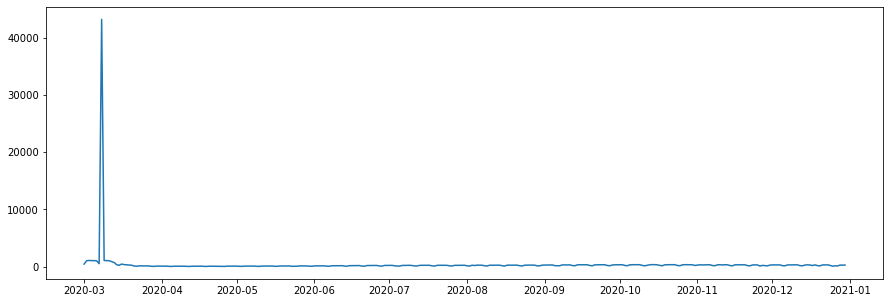

In [32]:
plt.figure(figsize = (15,5))
plt.plot(tmp1.date, tmp1.daily_entries)

#### March data is significantly higher than other months, let's take a further look.

In [33]:
tmp1.sort_values(by = "daily_entries", ascending = False)

,date,daily_entries
7,2020-03-08,43199.5
2,2020-03-03,1079.0
8,2020-03-09,1074.5
4,2020-03-05,1054.5
9,2020-03-10,1053.0
...,...,...
41,2020-04-11,42.0
35,2020-04-05,38.0
49,2020-04-19,38.0
56,2020-04-26,36.0


In [34]:
tmp1_mar_check = tmp1[(tmp1["date"] >= "2020-03-01") & (tmp1["date"] < "2020-03-15")]


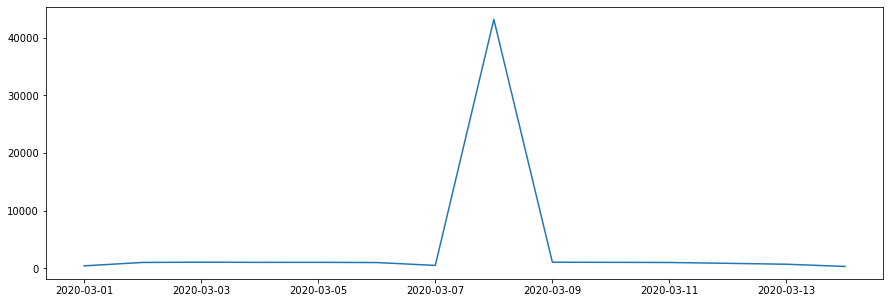

In [35]:
plt.figure(figsize = (15,5))
plt.plot(tmp1_mar_check.date, tmp1_mar_check.daily_entries)

#### The extreme value appears in 2020-03-08, let's pull it from the master data

In [47]:
df_mta_master[(df_mta_master['date'] == "2020-03-08")].sort_values("daily_entries", ascending = False)

,CA,unit,SCP,station,linename,division,date,desc,entries,exits,date_next,entries_next,daily_entries,week_begin,borough,year_month
113964,R325,R388,00-00-00,E 180 ST,25,IRT,2020-03-08,REGULAR,1489137,1842745,2020-11-02,9812.0,1479325.0,2020-03-02,bx,2020-03
95072,R507,R134,00-03-03,HUNTERS PT AV,7,IRT,2020-03-08,REGULAR,31565,25749,2020-11-02,1277937.0,1246372.0,2020-03-02,q,2020-03
8065,R647,R110,02-05-00,FLATBUSH AV-B.C,25,IRT,2020-03-08,REGULAR,1174495,1232813,2020-11-02,3109.0,1171386.0,2020-03-02,bk,2020-03
422332,N095,R014,00-03-08,FULTON ST,ACJZ2345,IND,2020-03-08,REGULAR,1190315,2355543,2020-11-02,20885.0,1169430.0,2020-03-02,m,2020-03
116027,R315,R406,01-00-00,PROSPECT AV,25,IRT,2020-03-08,REGULAR,1080701,1773230,2020-10-05,8.0,1080693.0,2020-03-02,bx,2020-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62883,R532,R328,00-05-04,METS-WILLETS PT,7,IRT,2020-03-08,REGULAR,253449,19714,2020-11-02,253450.0,1.0,2020-03-02,q,2020-03
102160,R422,R428,00-05-00,BUHRE AV,6,IRT,2020-03-08,REGULAR,527,0,2020-11-02,528.0,1.0,2020-03-02,bx,2020-03
62880,R532,R328,00-06-01,METS-WILLETS PT,7,IRT,2020-03-08,REGULAR,33647281,49112,2020-11-02,33647282.0,1.0,2020-03-02,q,2020-03
62877,R532,R328,00-06-04,METS-WILLETS PT,7,IRT,2020-03-08,REGULAR,169331,19750,2020-11-02,169332.0,1.0,2020-03-02,q,2020-03


In [52]:
# Remove the data point of 2020-03-08 as it was identified as an outlier and it will skew the data a lot when we calculate the avg weekly entries
df_mta_masterV2 = df_mta_master[(df_mta_master["date"] != "2020-03-08")]

In [53]:
tmp1 = df_mta_masterV2.groupby(["date"])["daily_entries"].median().reset_index()

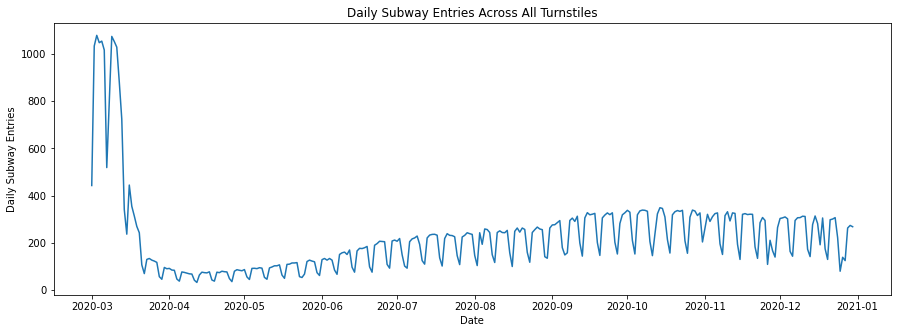

In [56]:
plt.figure(figsize = (15,5))
plt.plot(tmp1.date, tmp1.daily_entries)

plt.title("Daily Subway Entries Across All Turnstiles")
plt.xlabel("Date")
plt.ylabel("Daily Subway Entries");

In [57]:
#Visualize the data by borough
tmp2 = df_mta_masterV2.groupby(["borough","date"])["daily_entries"].median().reset_index()


/Users/wentingdeng/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


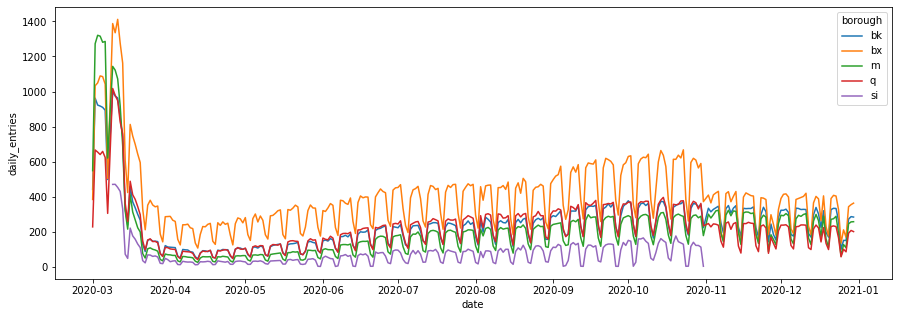

In [58]:
plt.figure(figsize = (15,5))
sns.lineplot("date","daily_entries", data = tmp2, hue = "borough");

### It looks SI(Staten Island) is missing data after 2020-11

# Check BX data in Jul 2020
tmp2[(tmp2['borough'] == 'bx') &
    (tmp2['date'] >= '2020-07-15') &
    (tmp2['date'] < '2020-08-01')].sort_values(by = 'daily_entries', ascending = False).head(5)

check_bx_jul = df_mta_masterV2[(df_mta_masterV2['date'] == '2020-07-24') &
                              (df_mta_masterV2['borough'] == 'bx')]

check_bx_jul.sort_values(by = 'daily_entries', ascending = False).head(5)

mask = ((df_mta_masterV2['CA'] == 'N218') &
        (df_mta_masterV2['unit'] == 'R112') &
        (df_mta_master['SCP'] == '01-06-00') &
        (df_mta_master['station'] == 'FORDHAM RD') &
        (df_mta_master['year_month'] == '2020-07')
       )



df_mta_masterV2[mask].sort_values(by = 'date').tail()

# delete the 2020-07-24 data point because it will skew the data a lot when we calculate the average weekly entries
idx = df_mta_masterV2[(df_mta_masterV2['CA'] == 'N218') &
        (df_mta_masterV2['unit'] == 'R112') &
        (df_mta_master['SCP'] == '01-06-00') &
        (df_mta_master['station'] == 'FORDHAM RD') &
        (df_mta_master['date'] == '2020-07-24')].index

df_mta_masterV2.drop(idx, inplace = True)


tmp2 = df_mta_masterV2.groupby(["borough","date"])["daily_entries"].median().reset_index()

plt.figure(figsize = (15,5))
sns.lineplot("date","daily_entries", data = tmp2, hue = "borough");

tmp2.date.max()

### Data Analysis

In [59]:
# Accoridng to the Covid data documentation, the #Covid cases is not accurate, and they recomended to use the death count instead.
# In this analysis I use the Covd death count as an indicator of Covid epidemic.
df_covid = pd.read_sql(
                        '''SELECT 
                               date(substr(date_of_interest,7,7) ||'-'||substr(date_of_interest,1,2)||'-'||substr(date_of_interest,4,2)) AS date
                               ,SUM(BX_DEATH_COUNT) as bx
                               ,SUM(MN_DEATH_COUNT) AS m
                               ,SUM(QN_DEATH_COUNT) AS q
                               ,SUM(SI_DEATH_COUNT) AS si
                               ,SUM(BK_DEATH_COUNT) AS bk
                            FROM df_covid
                            GROUP BY 1''', engine)
df_covid.head()

,date,bx,m,q,si,bk
0,2020-02-29,0,0,0,0,0
1,2020-03-01,0,0,0,0,0
2,2020-03-02,0,0,0,0,0
3,2020-03-03,0,0,0,0,0
4,2020-03-04,0,0,0,0,0


In [60]:
#Pivot the table in order to join it with the mta master data
df_covid_t = df_covid.melt(id_vars = ["date"],
                                    var_name = "borough",
                                    value_name = "cases")
df_covid_t.head()

,date,borough,cases
0,2020-02-29,bx,0
1,2020-03-01,bx,0
2,2020-03-02,bx,0
3,2020-03-03,bx,0
4,2020-03-04,bx,0


In [61]:
df_covid_t["date"] = pd.to_datetime(df_covid_t["date"], format = "%Y-%m-%d")
df_covid_t['week_begin'] = df_covid_t["date"] - pd.to_timedelta(df_covid_t["date"]
                                                                          .dt.dayofweek, unit='d')

In [62]:
df_covid_t.head()

,date,borough,cases,week_begin
0,2020-02-29,bx,0,2020-02-24
1,2020-03-01,bx,0,2020-02-24
2,2020-03-02,bx,0,2020-03-02
3,2020-03-03,bx,0,2020-03-02
4,2020-03-04,bx,0,2020-03-02


In [64]:
#Create the dataset to groupby the entries and covid cases into weekly basis.
df_mta_weekly_all = df_mta_masterV2.groupby("week_begin")["daily_entries"].median().reset_index()
df_covid_weekly_all = df_covid_t.groupby("week_begin")['cases'].median().reset_index()

df_mta_weekly_all.rename(columns = {"daily_entries" : "weekly_entries"}, inplace = True)

In [66]:
#append COVID cases to df_mta_tmp1
mta_covid_weekly_all = df_mta_weekly_all.merge(df_covid_weekly_all,
                                on = ["week_begin"],
                                how = "inner")

In [67]:
mta_covid_weekly_all.head()

,week_begin,weekly_entries,cases
0,2020-02-24,443.0,0
1,2020-03-02,938.0,0
2,2020-03-09,694.0,0
3,2020-03-16,235.0,4
4,2020-03-23,101.0,30


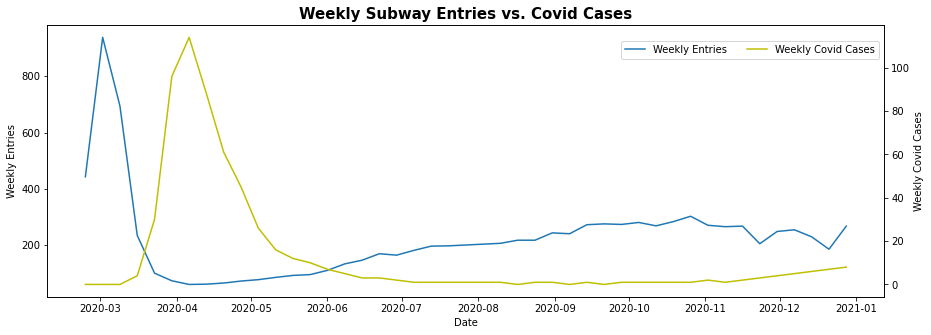

In [162]:
fig, ax = plt.subplots(figsize = (15,5))
line1, =ax.plot(mta_covid_weekly_all.week_begin,mta_covid_weekly_all.weekly_entries, label = 'weekly_entries')
ax.set_xlabel("Date")
ax.set_ylabel("Weekly Entries")


ax2 = ax.twinx()
line2, =ax2.plot(mta_covid_weekly_all.week_begin, mta_covid_weekly_all.cases, label = 'weekly_cases', c = 'y')
ax2.set_ylabel("Weekly Covid Cases")

plt.title("Weekly Subway Entries vs. Covid Cases", size = 15, fontweight='bold')
fig.legend([line1, line2], ['Weekly Entries', 'Weekly Covid Cases'], bbox_to_anchor=[0.9, 0.85], 
           ncol=2)

Given the patterns observed above, I further broke down the data into two:
  * Covid Early Stage: 2020-01-01 - 2020-05-31 
  * Covid Mid-Term: 2020-06-01 - 2020-10-31
  
Notes: Holiday season was excluded from this analysis because some Staten Island is missing data after Nov 2020 as the data imcomplete issues in the station mapping file

In [105]:
mta_covid_weekly_all_early = mta_covid_weekly_all[mta_covid_weekly_all.week_begin < "2020-06-01"]

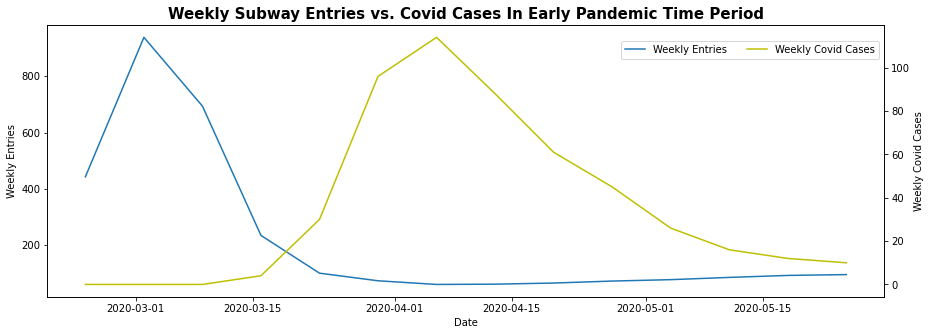

In [163]:
fig, ax = plt.subplots(figsize = (15,5))
line1, = ax.plot(mta_covid_weekly_all_early.week_begin,mta_covid_weekly_all_early.weekly_entries, label = 'weekly_entries')
ax.set_xlabel("Date")
ax.set_ylabel("Weekly Entries")


ax2 = ax.twinx()
lien2, = ax2.plot(mta_covid_weekly_all_early.week_begin, mta_covid_weekly_all_early.cases, label = 'weekly_cases', c = 'y')
ax2.set_ylabel("Weekly Covid Cases")

plt.title("Weekly Subway Entries vs. Covid Cases In Early Pandemic Time Period", size = 15, fontweight='bold')
fig.legend([line1,line2],['Weekly Entries', 'Weekly Covid Cases'], bbox_to_anchor=[0.9, 0.85],ncol=2);

In [116]:
#Consider the lag of subway riderships and exposure of Covid cases I added a 4 weeks lag here
mta_covid_weekly_all_early['cases_shift'] = mta_covid_weekly_all_early.cases.shift(-4)

<ipython-input-116-d0c92d07ac8b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mta_covid_weekly_all_early['cases_shift'] = mta_covid_weekly_all_early.cases.shift(-4)


In [117]:
mta_covid_weekly_all_early_shift = mta_covid_weekly_all_early[mta_covid_weekly_all_early["cases_shift"].notnull()]

In [118]:
np.corrcoef(mta_covid_weekly_all_early_shift.weekly_entries, mta_covid_weekly_all_early_shift.cases_shift)

array([[1.        , 0.74314761],
       [0.74314761, 1.        ]])

In [120]:
mta_covid_weekly_all_later = mta_covid_weekly_all[(mta_covid_weekly_all.week_begin >= "2020-06-01") &
                                                 (mta_covid_weekly_all.week_begin < "2020-11-01")]

In [121]:
np.corrcoef(mta_covid_weekly_all_later.weekly_entries, mta_covid_weekly_all_later.cases)

array([[ 1.        , -0.72568767],
       [-0.72568767,  1.        ]])

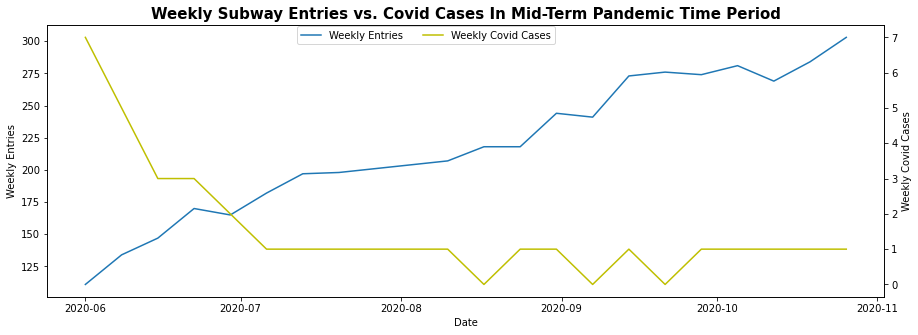

In [173]:
fig, ax = plt.subplots(figsize = (15,5))
line1, = ax.plot(mta_covid_weekly_all_later.week_begin,mta_covid_weekly_all_later.weekly_entries, label = 'weekly_entries')
ax.set_xlabel("Date")
ax.set_ylabel("Weekly Entries")


ax2 = ax.twinx()
line2, = ax2.plot(mta_covid_weekly_all_later.week_begin, mta_covid_weekly_all_later.cases, label = 'weekly_cases', c = 'y')
ax2.set_ylabel("Weekly Covid Cases")

plt.title("Weekly Subway Entries vs. Covid Cases In Mid-Term Pandemic Time Period", size = 15, fontweight='bold')
fig.legend([line1, line2],['Weekly Entries', 'Weekly Covid Cases'], bbox_to_anchor = [0.6, 0.89],ncol=2);



In [124]:
# Added lag here. After testing, lag 1 returns the highest correlation.
mta_covid_weekly_all_later["cases_shift"] = mta_covid_weekly_all_later['cases'].shift(-1)
mta_covid_weekly_all_later_shift= mta_covid_weekly_all_later[mta_covid_weekly_all_later["cases_shift"].notnull()]

<ipython-input-124-d95c5e091a7c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mta_covid_weekly_all_later["cases_shift"] = mta_covid_weekly_all_later['cases'].shift(-1)


In [125]:
np.corrcoef(mta_covid_weekly_all_later_shift.weekly_entries, mta_covid_weekly_all_later_shift.cases_shift)

array([[ 1.        , -0.70675273],
       [-0.70675273,  1.        ]])

### Analysis By Borough

In [143]:
df_mta_weekly_by_borough = df_mta_masterV2.groupby(["borough","week_begin"])["daily_entries"].median().reset_index()
df_mta_weekly_by_borough.rename(columns = {"daily_entries" : "weekly_entries"}, inplace = True)

In [144]:
df_covid_weekly_by_borough = df_covid_t.groupby(["borough","week_begin"])["cases"].median().reset_index()
df_covid_weekly_by_borough.head()

,borough,week_begin,cases
0,bk,2020-02-24,0
1,bk,2020-03-02,0
2,bk,2020-03-09,0
3,bk,2020-03-16,6
4,bk,2020-03-23,50


In [145]:
mta_covid_weekly_by_borough = df_mta_weekly_by_borough.merge(df_covid_weekly_by_borough,
                                                            on = ["borough", "week_begin"],
                                                            how = "inner")
mta_covid_weekly_by_borough.head()

,borough,week_begin,weekly_entries,cases
0,bk,2020-02-24,441.0,0
1,bk,2020-03-02,835.0,0
2,bk,2020-03-09,651.0,0
3,bk,2020-03-16,259.5,6
4,bk,2020-03-23,118.5,50


In [198]:
bk = mta_covid_weekly_by_borough[(mta_covid_weekly_by_borough.borough == 'bk') &
                                (mta_covid_weekly_by_borough.week_begin < "2020-11-01")]
bx = mta_covid_weekly_by_borough[(mta_covid_weekly_by_borough.borough == 'bx') &
                                (mta_covid_weekly_by_borough.week_begin < "2020-11-01")]
m = mta_covid_weekly_by_borough[(mta_covid_weekly_by_borough.borough == 'm') &
                                (mta_covid_weekly_by_borough.week_begin < "2020-11-01")]
q = mta_covid_weekly_by_borough[(mta_covid_weekly_by_borough.borough == 'q') &
                                (mta_covid_weekly_by_borough.week_begin < "2020-11-01")]
si = mta_covid_weekly_by_borough[(mta_covid_weekly_by_borough.borough == 'si') &
                                (mta_covid_weekly_by_borough.week_begin < "2020-11-01")]

In [199]:
bk_pre = bk[bk['week_begin'] < "2020-06-01"]
bx_pre = bx[bx['week_begin'] < "2020-06-01"]
m_pre = m[m['week_begin'] < "2020-06-01"]
q_pre = q[q['week_begin'] < "2020-06-01"]
si_pre = si[si['week_begin'] < "2020-06-01"]



bk_later = bk[bk['week_begin'] >= "2020-06-01"]
bx_later = bx[bx['week_begin'] >= "2020-06-01"]
m_later = m[m['week_begin'] >= "2020-06-01"]
q_later = q[q['week_begin'] >= "2020-06-01"]
si_later = si[si['week_begin'] >= "2020-06-01"]

In [ ]:
#Brooklyn

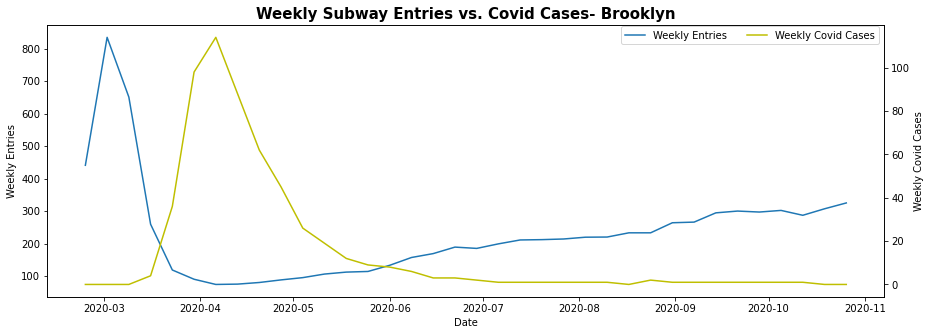

In [210]:
fig, ax = plt.subplots(figsize = (15,5))
line1, = ax.plot(bk.week_begin,bk.weekly_entries, label = 'weekly_entries')
ax.set_xlabel("Date")
ax.set_ylabel("Weekly Entries")


ax2 = ax.twinx()
line2, = ax2.plot(bk.week_begin, bx.cases, label = 'weekly_cases', c = 'y')
ax2.set_ylabel("Weekly Covid Cases")

plt.title("Weekly Subway Entries vs. Covid Cases- Brooklyn", size = 15, fontweight='bold')
fig.legend([line1, line2],['Weekly Entries', 'Weekly Covid Cases'], bbox_to_anchor = [0.9, 0.89],ncol=2);



In [201]:
bk_pre['cases_shift'] = bk_pre.cases.shift(-4)

<ipython-input-201-d2d7f0a53f92>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bk_pre['cases_shift'] = bk_pre.cases.shift(-4)


In [202]:
bk_pre_shift = bk_pre[bk_pre['cases_shift'].notnull()]
bk_pre_shift.head()

,borough,week_begin,weekly_entries,cases,cases_shift
0,bk,2020-02-24,441.0,0,50.0
1,bk,2020-03-02,835.0,0,143.0
2,bk,2020-03-09,651.0,0,178.0
3,bk,2020-03-16,259.5,6,126.0
4,bk,2020-03-23,118.5,50,93.0


In [203]:
np.corrcoef(bk_pre_shift.weekly_entries, bk_pre_shift.cases_shift)

array([[1.        , 0.77593326],
       [0.77593326, 1.        ]])

In [204]:
bk_later['cases_shift'] = bk_later.cases.shift(-1)
bk_later.head()

<ipython-input-204-bb535434c301>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bk_later['cases_shift'] = bk_later.cases.shift(-1)


,borough,week_begin,weekly_entries,cases,cases_shift
14,bk,2020-06-01,133.0,10,6.0
15,bk,2020-06-08,157.0,6,4.0
16,bk,2020-06-15,169.0,4,5.0
17,bk,2020-06-22,189.0,5,3.0
18,bk,2020-06-29,185.0,3,2.0


In [205]:
bk_later_shift = bk_later[bk_later['cases_shift'].notnull()]

In [206]:
np.corrcoef(bk_later_shift.weekly_entries, bk_later_shift.cases_shift)

array([[ 1.        , -0.51652352],
       [-0.51652352,  1.        ]])

In [207]:
np.corrcoef(bk_later.weekly_entries, bk_later.cases)

array([[ 1.        , -0.59202475],
       [-0.59202475,  1.        ]])

In [ ]:
#Bronx 

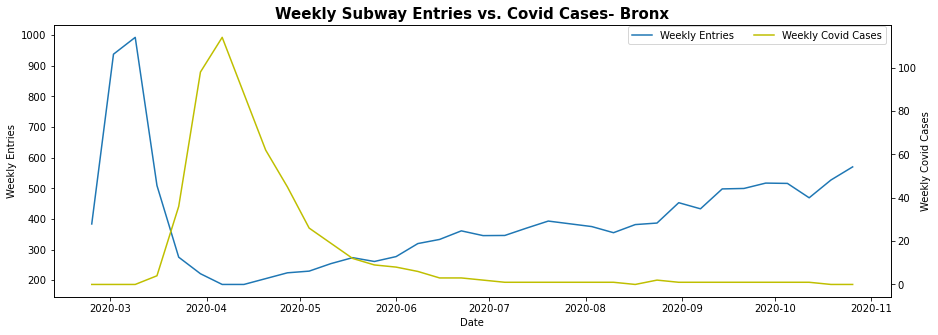

In [211]:
fig, ax = plt.subplots(figsize = (15,5))
line1, = ax.plot(bx.week_begin,bx.weekly_entries, label = 'weekly_entries')
ax.set_xlabel("Date")
ax.set_ylabel("Weekly Entries")


ax2 = ax.twinx()
line2, = ax2.plot(bx.week_begin, bx.cases, label = 'weekly_cases', c = 'y')
ax2.set_ylabel("Weekly Covid Cases")

plt.title("Weekly Subway Entries vs. Covid Cases- Bronx", size = 15, fontweight='bold')
fig.legend([line1, line2],['Weekly Entries', 'Weekly Covid Cases'], bbox_to_anchor = [0.9, 0.89],ncol=2);



In [212]:
bx_pre['cases_shift'] = bx_pre.cases.shift(-4)

<ipython-input-212-5c26ecc566df>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bx_pre['cases_shift'] = bx_pre.cases.shift(-4)


In [213]:
bx_pre_shift = bx_pre[bx_pre['cases_shift'].notnull()]
bx_pre_shift.head()

,borough,week_begin,weekly_entries,cases,cases_shift
45,bx,2020-02-24,383.5,0,36.0
46,bx,2020-03-02,938.0,0,98.0
47,bx,2020-03-09,993.0,0,114.0
48,bx,2020-03-16,509.0,4,88.0
49,bx,2020-03-23,275.0,36,62.0


In [214]:
np.corrcoef(bx_pre_shift.weekly_entries, bx_pre_shift.cases_shift)

array([[1.        , 0.89210666],
       [0.89210666, 1.        ]])

In [221]:
bx_later['cases_shift'] = bx_later.cases.shift(-1)
bx_later.head()

<ipython-input-221-42847dcbbfac>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bx_later['cases_shift'] = bx_later.cases.shift(-1)


,borough,week_begin,weekly_entries,cases,cases_shift
59,bx,2020-06-01,277.0,8,6.0
60,bx,2020-06-08,319.5,6,3.0
61,bx,2020-06-15,333.0,3,3.0
62,bx,2020-06-22,361.0,3,2.0
63,bx,2020-06-29,345.5,2,1.0


In [222]:
bx_later_shift = bx_later[bx_later['cases_shift'].notnull()]

In [223]:
np.corrcoef(bx_later_shift.weekly_entries, bx_later_shift.cases_shift)

array([[ 1.        , -0.60193708],
       [-0.60193708,  1.        ]])

In [ ]:
#Manhattan 

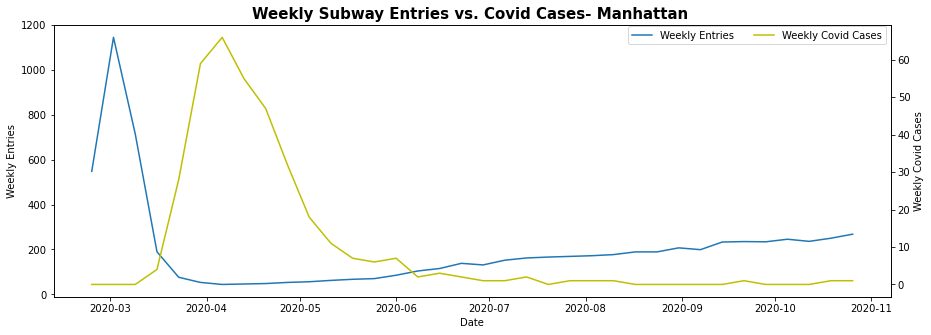

In [224]:
fig, ax = plt.subplots(figsize = (15,5))
line1, = ax.plot(m.week_begin,m.weekly_entries, label = 'weekly_entries')
ax.set_xlabel("Date")
ax.set_ylabel("Weekly Entries")


ax2 = ax.twinx()
line2, = ax2.plot(m.week_begin, m.cases, label = 'weekly_cases', c = 'y')
ax2.set_ylabel("Weekly Covid Cases")

plt.title("Weekly Subway Entries vs. Covid Cases- Manhattan", size = 15, fontweight='bold')
fig.legend([line1, line2],['Weekly Entries', 'Weekly Covid Cases'], bbox_to_anchor = [0.9, 0.89],ncol=2);


In [225]:
m_pre['cases_shift'] = m_pre.cases.shift(-4)

<ipython-input-225-78ac91ac1c6b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_pre['cases_shift'] = m_pre.cases.shift(-4)


In [227]:
m_pre_shift = m_pre[m_pre['cases_shift'].notnull()]
m_pre_shift.head()

,borough,week_begin,weekly_entries,cases,cases_shift
90,m,2020-02-24,548.0,0,28.0
91,m,2020-03-02,1145.0,0,59.0
92,m,2020-03-09,715.0,0,66.0
93,m,2020-03-16,189.5,4,55.0
94,m,2020-03-23,76.0,28,47.0


In [228]:
np.corrcoef(m_pre_shift.weekly_entries, m_pre_shift.cases_shift)

array([[1.        , 0.66389027],
       [0.66389027, 1.        ]])

In [229]:
m_later['cases_shift'] = m_later.cases.shift(-1)
m_later.head()

<ipython-input-229-7178b86991b0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_later['cases_shift'] = m_later.cases.shift(-1)


,borough,week_begin,weekly_entries,cases,cases_shift
104,m,2020-06-01,85.0,7,2.0
105,m,2020-06-08,104.0,2,3.0
106,m,2020-06-15,115.0,3,2.0
107,m,2020-06-22,138.0,2,1.0
108,m,2020-06-29,131.0,1,1.0


In [230]:
m_later_shift = m_later[m_later['cases_shift'].notnull()]

In [231]:
np.corrcoef(m_later_shift.weekly_entries, m_later_shift.cases_shift)

array([[ 1.        , -0.65675552],
       [-0.65675552,  1.        ]])

In [ ]:
#Queens

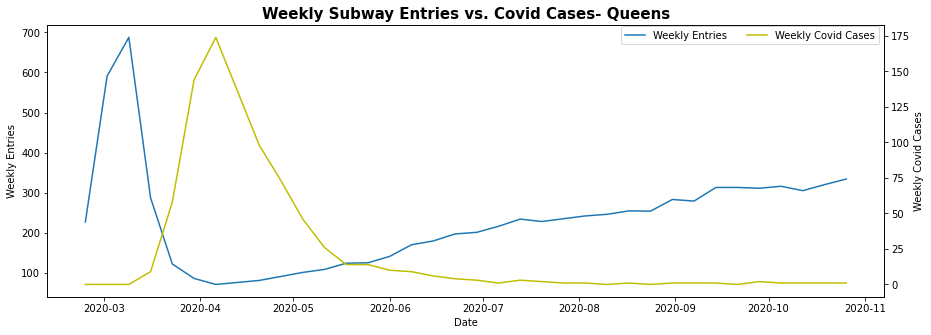

In [232]:
fig, ax = plt.subplots(figsize = (15,5))
line1, = ax.plot(q.week_begin,q.weekly_entries, label = 'weekly_entries')
ax.set_xlabel("Date")
ax.set_ylabel("Weekly Entries")


ax2 = ax.twinx()
line2, = ax2.plot(q.week_begin, q.cases, label = 'weekly_cases', c = 'y')
ax2.set_ylabel("Weekly Covid Cases")

plt.title("Weekly Subway Entries vs. Covid Cases- Queens", size = 15, fontweight='bold')
fig.legend([line1, line2],['Weekly Entries', 'Weekly Covid Cases'], bbox_to_anchor = [0.9, 0.89],ncol=2);


In [233]:
q_pre['cases_shift'] = q_pre.cases.shift(-4)

<ipython-input-233-06c7e9d6f0e0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  q_pre['cases_shift'] = q_pre.cases.shift(-4)


In [235]:
q_pre_shift = q_pre[q_pre['cases_shift'].notnull()]
q_pre_shift.head()

,borough,week_begin,weekly_entries,cases,cases_shift
135,q,2020-02-24,227.0,0,58.0
136,q,2020-03-02,591.0,0,144.0
137,q,2020-03-09,687.5,0,174.0
138,q,2020-03-16,287.0,9,136.0
139,q,2020-03-23,122.0,58,98.0


In [236]:
np.corrcoef(q_pre_shift.weekly_entries, q_pre_shift.cases_shift)

array([[1.        , 0.86067409],
       [0.86067409, 1.        ]])

In [237]:
q_later['cases_shift'] = q_later.cases.shift(-1)
q_later.head()

<ipython-input-237-7c8c472b6ab4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  q_later['cases_shift'] = q_later.cases.shift(-1)


,borough,week_begin,weekly_entries,cases,cases_shift
149,q,2020-06-01,141.0,10,9.0
150,q,2020-06-08,170.0,9,6.0
151,q,2020-06-15,179.5,6,4.0
152,q,2020-06-22,197.0,4,3.0
153,q,2020-06-29,201.0,3,1.0


In [238]:
q_later_shift = q_later[q_later['cases_shift'].notnull()]

In [239]:
np.corrcoef(q_later_shift.weekly_entries, q_later_shift.cases_shift)

array([[ 1.       , -0.7202766],
       [-0.7202766,  1.       ]])

In [ ]:
#Staten Island 

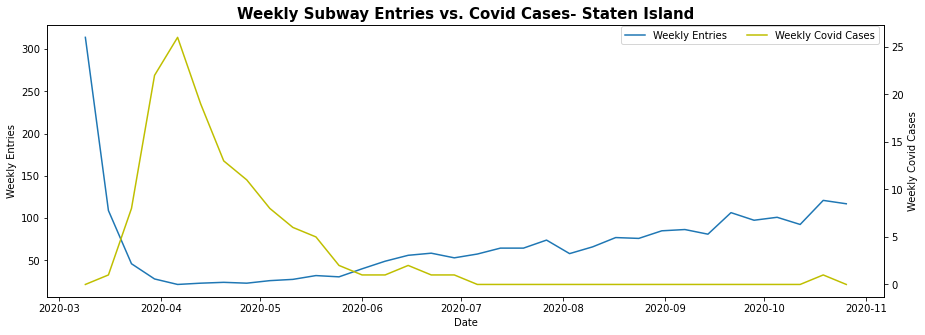

In [241]:
fig, ax = plt.subplots(figsize = (15,5))
line1, = ax.plot(si.week_begin,si.weekly_entries, label = 'weekly_entries')
ax.set_xlabel("Date")
ax.set_ylabel("Weekly Entries")


ax2 = ax.twinx()
line2, = ax2.plot(si.week_begin, si.cases, label = 'weekly_cases', c = 'y')
ax2.set_ylabel("Weekly Covid Cases")

plt.title("Weekly Subway Entries vs. Covid Cases- Staten Island", size = 15, fontweight='bold')
fig.legend([line1, line2],['Weekly Entries', 'Weekly Covid Cases'], bbox_to_anchor = [0.9, 0.89],ncol=2);


In [242]:
si_pre['cases_shift'] = si_pre.cases.shift(-4)

<ipython-input-242-65a129d7cb13>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  si_pre['cases_shift'] = si_pre.cases.shift(-4)


In [243]:
si_pre_shift = si_pre[si_pre['cases_shift'].notnull()]
si_pre_shift.head()

,borough,week_begin,weekly_entries,cases,cases_shift
180,si,2020-03-09,314.0,0,26.0
181,si,2020-03-16,109.0,1,19.0
182,si,2020-03-23,46.0,8,13.0
183,si,2020-03-30,28.0,22,11.0
184,si,2020-04-06,21.5,26,8.0


In [244]:
np.corrcoef(si_pre_shift.weekly_entries, si_pre_shift.cases_shift)

array([[1.        , 0.88306893],
       [0.88306893, 1.        ]])

In [245]:
si_later['cases_shift'] = si_later.cases.shift(-1)
si_later.head()

<ipython-input-245-26c6c2296ced>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  si_later['cases_shift'] = si_later.cases.shift(-1)


,borough,week_begin,weekly_entries,cases,cases_shift
192,si,2020-06-01,40.0,1,1.0
193,si,2020-06-08,49.0,1,2.0
194,si,2020-06-15,56.0,2,1.0
195,si,2020-06-22,58.5,1,1.0
196,si,2020-06-29,53.0,1,0.0


In [246]:
si_later_shift = si_later[si_later['cases_shift'].notnull()]

In [247]:
np.corrcoef(si_later_shift.weekly_entries, si_later_shift.cases_shift)

array([[ 1.        , -0.43476323],
       [-0.43476323,  1.        ]])

### Insights Highligt
  * In the early pandemic period, subway station foot traffic and Covid cases showed strong correlations with a 4 weeks lag. When the trend of subway foot traffic went up, which could indicate the trend up of Covid cases after about 4 weeks. 
  * The correlation became negative druing the midterm stage, started from 2020-06.
    * The lag became shorter. It could be explained as more advanced Covid test methods were available and it enabled people to test COVID faster;
    * Negative correlations indicated the way that people engaging with Covid also changed. While people know more about the virus, they may prefer staying at home to protect themselves. In the meantime, the goverment and health organizations started to take actions to control the spread of Covid, such as locked down the city, produced vaccines etc. 
  * Although it shows negative correlations between Subway traffic and Covid cases, we still need to pay attention to those stations with high volume of traffic, otherwise as the foot traffic increases another wave of Covid may break out again.
  
### Next Step:
As my analysis objective is to find stations which need more supplies in covid hygiene kits. I'm going to identify the stations with large traffic volume and also show significant increase in foot traffic during the midterm period.